# Importing the libraries

In [399]:
import time
program_start = time.time()
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
print(tf.__version__)
import math
from sklearn.metrics import mean_squared_error
import os

2.2.0


# Importing the dataset

In [400]:
#len(pd.bdate_range(start=fya, end=yesterday))

In [401]:
yesterday = date.today() - timedelta(days = 1)
print(yesterday)
fya = yesterday - timedelta(days = 365 * 5)
print(fya)

2020-07-20
2015-07-22


In [402]:
ticker = 'AAPL'
TIINGO_API_KEY = '0d89b22b2baae6031d933255d95b27b45630fa18'
#api_key=os.environ.get('TIINGO_API_KEY')
df = pdr.get_data_tiingo(ticker, api_key=TIINGO_API_KEY, 
                         start = fya, end = yesterday)

# Data preprocessing

## Converting JSON to CSV

In [403]:
df.to_csv('{0}.csv'.format(ticker))
df.head()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
AAPL   2015-07-22 00:00:00+00:00  125.22  125.50  ...      0.0          1.0
       2015-07-23 00:00:00+00:00  125.16  127.09  ...      0.0          1.0
       2015-07-24 00:00:00+00:00  124.50  125.74  ...      0.0          1.0
       2015-07-27 00:00:00+00:00  122.77  123.61  ...      0.0          1.0
       2015-07-28 00:00:00+00:00  123.38  123.91  ...      0.0          1.0

[5 rows x 12 columns]

## Forming dataframe of close prices

In [544]:
df1 = df.reset_index()['close']

In [405]:
df1.shape

(1258,)

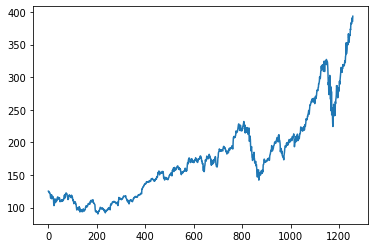

In [406]:
plt.plot(df1)

## Feature scaling using MinMax Scaler (Values between 0 to 1)

In [545]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [408]:
df1.shape

(1258, 1)

## Splitting dataset into training set and test set sequentialy

In [409]:
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = (df1[0:training_size, :], 
                         df1[training_size:len(df1), :1])
print(train_data.shape)
print(test_data.shape)

(817, 1)
(441, 1)


In [410]:
train_data

array([[0.11508133],
       [0.11488337],
       [0.1127058 ],
       [0.10699792],
       [0.10901052],
       [0.10772378],
       [0.10567818],
       [0.10214788],
       [0.09271174],
       [0.08017421],
       [0.08268171],
       [0.08179089],
       [0.08307763],
       [0.0969349 ],
       [0.07637995],
       [0.08215382],
       [0.08185687],
       [0.08452935],
       [0.08848857],
       [0.086311  ],
       [0.08139497],
       [0.0736085 ],
       [0.05087598],
       [0.04216569],
       [0.04421129],
       [0.06384242],
       [0.07449932],
       [0.07572008],
       [0.07397143],
       [0.0573427 ],
       [0.0725857 ],
       [0.06608598],
       [0.0624567 ],
       [0.07248672],
       [0.06536012],
       [0.07334455],
       [0.07875549],
       [0.08238477],
       [0.08558514],
       [0.08601406],
       [0.07779867],
       [0.07624798],
       [0.08205484],
       [0.07608301],
       [0.07911841],
       [0.08136197],
       [0.08040516],
       [0.072

In [411]:
pd.DataFrame(test_data).head()

,0
0,0.431720
1,0.414662
2,0.425517
3,0.429938
4,0.436801


## Creating array of independent and dependent variables(X_train, y_train, X_test, y_test)

In [602]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[(i+time_step), 0])
  return np.array(dataX), np.array(dataY)

In [636]:
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [637]:
X_train

array([[0.11508133, 0.11488337, 0.1127058 , ..., 0.07291564, 0.06176383,
        0.06585503],
       [0.11488337, 0.1127058 , 0.10699792, ..., 0.06176383, 0.06585503,
        0.06347949],
       [0.1127058 , 0.10699792, 0.10901052, ..., 0.06585503, 0.06347949,
        0.06611897],
       ...,
       [0.36675575, 0.38618892, 0.38816853, ..., 0.44023227, 0.45046026,
        0.41578409],
       [0.38618892, 0.38816853, 0.39173183, ..., 0.45046026, 0.41578409,
        0.40948233],
       [0.38816853, 0.39173183, 0.3852651 , ..., 0.41578409, 0.40948233,
        0.43475535]])

In [638]:
print(X_train.shape)

(766, 50)


In [639]:
pd.DataFrame(y_train).head()

,0
0,0.063479
1,0.066119
2,0.067439
3,0.069187
4,0.067439


In [640]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.431720,0.414662,0.425517,0.429938,0.436801,0.411594,0.427134,0.415586,0.402191,0.405688,0.424032,0.435118,0.386486,0.367053,0.374245,0.394635,0.389818,0.376555,0.342572,0.336171,0.318255,0.333465,0.340460,0.315154,0.285856,0.285196,0.270382,0.278069,0.276815,0.298921,0.294335,0.291135,0.311723,0.284899,0.278399,0.257844,0.261506,0.258306,0.259857,0.265961,0.247913,0.242832,0.249860,0.232769,0.219374,0.199248,0.186380,0.220496,0.217130,0.217394
1,0.414662,0.425517,0.429938,0.436801,0.411594,0.427134,0.415586,0.402191,0.405688,0.424032,0.435118,0.386486,0.367053,0.374245,0.394635,0.389818,0.376555,0.342572,0.336171,0.318255,0.333465,0.340460,0.315154,0.285856,0.285196,0.270382,0.278069,0.276815,0.298921,0.294335,0.291135,0.311723,0.284899,0.278399,0.257844,0.261506,0.258306,0.259857,0.265961,0.247913,0.242832,0.249860,0.232769,0.219374,0.199248,0.186380,0.220496,0.217130,0.217394,0.222376
2,0.425517,0.429938,0.436801,0.411594,0.427134,0.415586,0.402191,0.405688,0.424032,0.435118,0.386486,0.367053,0.374245,0.394635,0.389818,0.376555,0.342572,0.336171,0.318255,0.333465,0.340460,0.315154,0.285856,0.285196,0.270382,0.278069,0.276815,0.298921,0.294335,0.291135,0.311723,0.284899,0.278399,0.257844,0.261506,0.258306,0.259857,0.265961,0.247913,0.242832,0.249860,0.232769,0.219374,0.199248,0.186380,0.220496,0.217130,0.217394,0.222376,0.222970
3,0.429938,0.436801,0.411594,0.427134,0.415586,0.402191,0.405688,0.424032,0.435118,0.386486,0.367053,0.374245,0.394635,0.389818,0.376555,0.342572,0.336171,0.318255,0.333465,0.340460,0.315154,0.285856,0.285196,0.270382,0.278069,0.276815,0.298921,0.294335,0.291135,0.311723,0.284899,0.278399,0.257844,0.261506,0.258306,0.259857,0.265961,0.247913,0.242832,0.249860,0.232769,0.219374,0.199248,0.186380,0.220496,0.217130,0.217394,0.222376,0.222970,0.171071
4,0.436801,0.411594,0.427134,0.415586,0.402191,0.405688,0.424032,0.435118,0.386486,0.367053,0.374245,0.394635,0.389818,0.376555,0.342572,0.336171,0.318255,0.333465,0.340460,0.315154,0.285856,0.285196,0.270382,0.278069,0.276815,0.298921,0.294335,0.291135,0.311723,0.284899,0.278399,0.257844,0.261506,0.258306,0.259857,0.265961,0.247913,0.242832,0.249860,0.232769,0.219374,0.199248,0.186380,0.220496,0.217130,0.217394,0.222376,0.222970,0.171071,0.191098


In [641]:
pd.DataFrame(y_test).head()

,0
0,0.222376
1,0.222970
2,0.171071
3,0.191098
4,0.190010


# Creating LSTM model

## Reshaping X_train and X_test into 3D arrays

In [642]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)

(766, 50, 1)


In [643]:
print(X_train)

[[[0.11508133]
  [0.11488337]
  [0.1127058 ]
  ...
  [0.07291564]
  [0.06176383]
  [0.06585503]]

 [[0.11488337]
  [0.1127058 ]
  [0.10699792]
  ...
  [0.06176383]
  [0.06585503]
  [0.06347949]]

 [[0.1127058 ]
  [0.10699792]
  [0.10901052]
  ...
  [0.06585503]
  [0.06347949]
  [0.06611897]]

 ...

 [[0.36675575]
  [0.38618892]
  [0.38816853]
  ...
  [0.44023227]
  [0.45046026]
  [0.41578409]]

 [[0.38618892]
  [0.38816853]
  [0.39173183]
  ...
  [0.45046026]
  [0.41578409]
  [0.40948233]]

 [[0.38816853]
  [0.39173183]
  [0.3852651 ]
  ...
  [0.41578409]
  [0.40948233]
  [0.43475535]]]


## Creating a sequential model

In [644]:
model = Sequential([
          LSTM(50, return_sequences=True, input_shape=(100,1)),
          LSTM(50, return_sequences=True),
          LSTM(50),
          Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [645]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_51 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_52 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## Training the sequential model

In [646]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=100, batch_size=64, verbose=2)

Epoch 1/100
12/12 - 1s - loss: 0.0109 - val_loss: 0.0348
Epoch 2/100
12/12 - 0s - loss: 0.0016 - val_loss: 0.0029
Epoch 3/100
12/12 - 0s - loss: 7.0386e-04 - val_loss: 0.0032
Epoch 4/100
12/12 - 0s - loss: 4.4990e-04 - val_loss: 0.0027
Epoch 5/100
12/12 - 0s - loss: 4.1031e-04 - val_loss: 0.0025
Epoch 6/100
12/12 - 0s - loss: 3.8198e-04 - val_loss: 0.0025
Epoch 7/100
12/12 - 0s - loss: 3.7814e-04 - val_loss: 0.0025
Epoch 8/100
12/12 - 0s - loss: 3.5884e-04 - val_loss: 0.0025
Epoch 9/100
12/12 - 0s - loss: 3.5494e-04 - val_loss: 0.0024
Epoch 10/100
12/12 - 0s - loss: 3.5735e-04 - val_loss: 0.0024
Epoch 11/100
12/12 - 0s - loss: 3.7651e-04 - val_loss: 0.0023
Epoch 12/100
12/12 - 0s - loss: 3.7894e-04 - val_loss: 0.0028
Epoch 13/100
12/12 - 0s - loss: 3.5577e-04 - val_loss: 0.0025
Epoch 14/100
12/12 - 0s - loss: 3.4417e-04 - val_loss: 0.0021
Epoch 15/100
12/12 - 0s - loss: 3.5967e-04 - val_loss: 0.0021
Epoch 16/100
12/12 - 0s - loss: 3.4941e-04 - val_loss: 0.0029
Epoch 17/100
12/12 - 0s -

## Prediction of training and test sets

In [647]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(train_pred.shape)
print(test_pred.shape)

(766, 1)
(390, 1)


In [648]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Analysing training and test set results

In [649]:
math.sqrt(mean_squared_error(y_train, train_pred))

146.37658356168203

In [650]:
math.sqrt(mean_squared_error(y_test, test_pred))

247.12432713386417

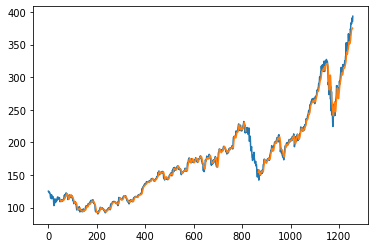

In [651]:
y_pred_plot = np.empty_like(df1)
y_pred_plot[:, :] = np.nan
y_pred_plot[time_step:len(train_pred)+time_step, :] = train_pred
#y_pred_plot = np.empty_like(df1)
#y_pred_plot[:,:] = np.nan
y_pred_plot[len(train_pred)+(time_step*2)+1:len(df1)-1, :] = test_pred
#y_pred_plot = np.append(y_pred_plot, test_pred)
plt.plot(scaler.inverse_transform(df1))
#plt.plot(train_pred_plot)
plt.plot(y_pred_plot)
plt.show()

In [652]:
pd.DataFrame(test_data).tail()

,0
436,0.982843
437,0.991653
438,0.975783
439,0.973209
440,1.000000


In [653]:
X_in = test_data[340:].reshape(1, -1)
X_in.shape

(1, 101)

In [601]:
temp_in = list(X_in)
temp_in = temp_in[0].tolist()

In [523]:
pd.DataFrame(temp_in).head()

,0
0,0.667492
1,0.604375
2,0.603847
3,0.687816
4,0.656505


In [524]:
list_output = []
n_steps = 100
days_ahead = 0
while(days_ahead<30):
  if (len(temp_in) > 100):
    X_in = np.array(temp_in[1:])
    #print("{0} day input {1}".format(i, X_in))
    X_in = X_in.reshape(1, -1)
    X_in = X_in.reshape((1, n_steps, 1))
    y_hat = model.predict(X_in, verbose=0)
    #print("{0} day output {1}".format(i, y_hat))
    temp_in.extend(y_hat[0].tolist())
    temp_in = temp_in[1:]
    list_output.extend(y_hat.tolist())
    days_ahead += 1
  else:
    X_in = X_in.reshape((1, n_steps, 1))
    y_hat = model.predict(X_in, verbose=0)
    #print(y_hat)
    temp_in.extend(y_hat[0].tolist())
    #print(len(temp_in))
    list_output.extend(y_hat.tolist())
    days_ahead +=1

  pd.DataFrame(list_output).head()

In [525]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, (101+days_ahead))

In [526]:
len(df1)

1258

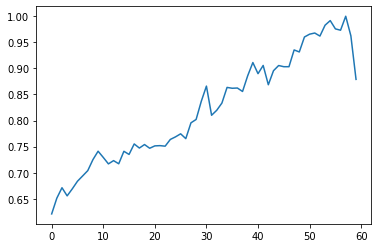

In [527]:
df3 = df1.tolist()
df3.extend(list_output)
plt.plot(df3[1200:])

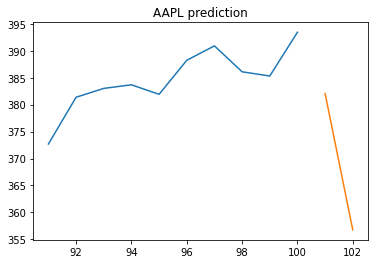

In [528]:
plt.plot(day_new[90:], scaler.inverse_transform(df1[(len(df1)-10):]))
plt.plot(day_pred, scaler.inverse_transform(list_output))
plt.title("{0} prediction".format(ticker))
plt.show()

In [529]:
program_end = time.time()
print(f"Runtime: {program_end - program_start}")

Runtime: 3961.200824022293
